# ECCO Data - cleaned version
Bottom Temperature and Salinity to compare with SOSE and WOA products

In [1]:
from dask_gateway import GatewayCluster

cluster = GatewayCluster()
cluster.scale(30)
#cluster.adapt(minimum=2, maximum=10)  # or cluster.scale(n) to a fixed size.
client = cluster.get_client()

In [2]:
client

Connection method: Cluster object,Cluster type: dask_gateway.GatewayCluster
Dashboard: /services/dask-gateway/clusters/prod.b89af71f9ec3473499d4256ee99bc9f3/status,


In [35]:
client.close()
cluster.close()

In [1]:
import xarray as xr
from matplotlib import pyplot as plt
import gcsfs
import dask
import dask.array as dsa
import numpy as np
import intake
import fsspec
import xmitgcm
import json
from xmitgcm.llcreader.llcmodel import faces_dataset_to_latlon
import matplotlib.ticker as mticker
import cartopy.crs as ccrs #cartopy coord ref sys
import cartopy
import cartopy.feature as cfeature
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
#import regionmask
#import plot_proj_to_latlon_grid

In [2]:
#bringing in uploaded ds

with open('/home/jovyan/pangeo-181919-f141378dc975.json') as token_file:
    token = json.load(token_file)
gcfs_w_token = gcsfs.GCSFileSystem(token=token)

def open_ds(filename):
    path = "pangeo-tmp/stb2145/models/ECCO/"
    return xr.open_zarr(gcfs_w_token.get_mapper(path + filename), consolidated=False)

ds_tns = open_ds('ds_tns_wg.zarr')
#coords = open_ds('coords_wg.zarr')

In [3]:
#all this to load in coords without roll_coords=True
ds = xr.open_zarr(gcsfs.GCSFileSystem(requester_pays=True).get_mapper('pangeo-ecco-eccov4r3/eccov4r3'), consolidated=True)
dt_values = (np.diff(ds.time_snp) / 1e9).astype('f4')
dt = xr.DataArray(dt_values, dims=['time'],
                  coords={'time': (['time'], ds.time.values[1:-1])})
ds.coords['dt'] = dt
ds_ll = faces_dataset_to_latlon(ds)
ds_ll_drop = ds_ll#.drop(['i', 'j', 'i_g', 'j_g']) #, 'k', 'k_u', 'k_l', 'k_p1'])
# a trick to make things work a bit faster
coordsr = ds_ll_drop.coords.to_dataset().reset_coords().roll(i=50, i_g=50)#(i=100, i_g=100)

#view current coord structure of i
coordsr.i.values
#locate 0, that's where -180 is
coordsr.i.values[50]
#create lon object to replace current i indexing
lon = np.arange(-180, 180)
#roll lon appropriately so new indexing values matches actual grid
lon_rolled = np.roll(lon, 50)
#insert new lon indices for both i & i_g
coordsr['i'] = lon_rolled
coordsr['i_g'] = lon_rolled

In [4]:
#WG boundaries (65˚W, 30˚E; 80˚S, 57˚S)
left_lon = 23 #~-64.5˚ #used to be 20
right_lon = 118 #30.5˚ #used to be 115
lower_lat = 30 #~-80˚ #used to be 38
upper_lat = 90 #-56.73891

#set the boundaries
lat_range = dict(j=slice(lower_lat, upper_lat))
lon_range = dict(i=slice(left_lon, right_lon))
lat_range_u = dict(j_g=slice(lower_lat, upper_lat))
lon_range_u = dict(i_g=slice(left_lon, right_lon))

coords = coordsr.isel(**lat_range, **lon_range, **lat_range_u, **lon_range_u)

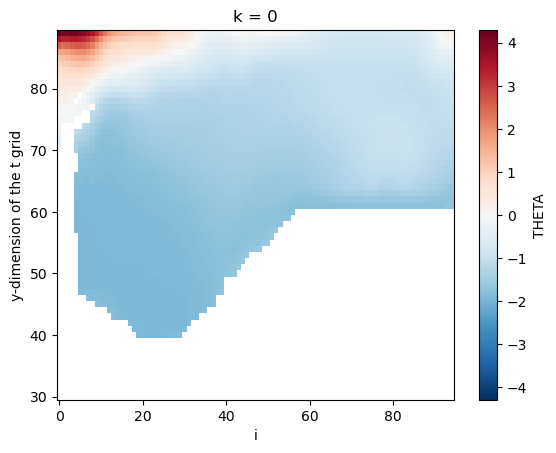

In [5]:
#testing to see if correctly sliced desired region
sst_mean = ds_tns.THETA.sel(k=0).mean(dim='time')
surface_mask = (coords.hFacC[0]>0)
sst_mean.where(surface_mask).drop('i').plot()

## <span style='color:Brown'> Bottom Potential Temperatures

In [6]:
#this gives us the depth of the bottom cell
depth_max = ds_tns.k.where(coords.hFacC > 0).max(dim='k').load()

/srv/conda/envs/notebook/lib/python3.9/site-packages/dask/array/reductions.py:640: RuntimeWarning: All-NaN slice encountered
  return np.nanmax(x_chunk, axis=axis, keepdims=keepdims)


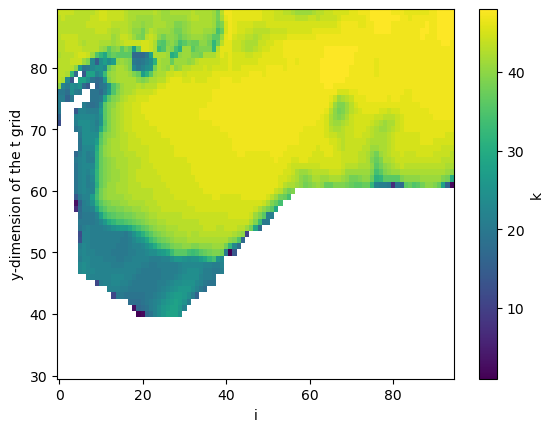

In [9]:
depth_max.drop('i').plot();

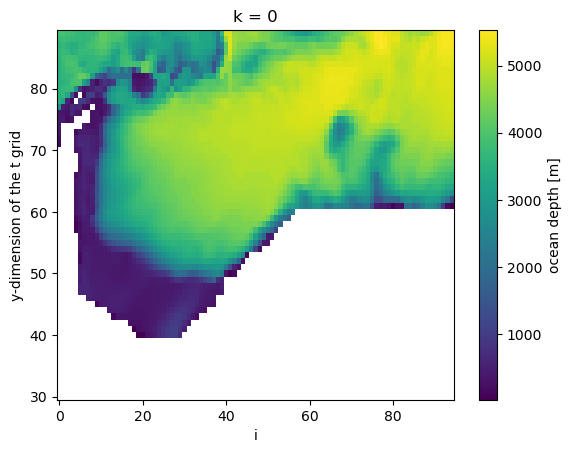

In [10]:
coords.Depth.where(surface_mask).drop('i').plot();

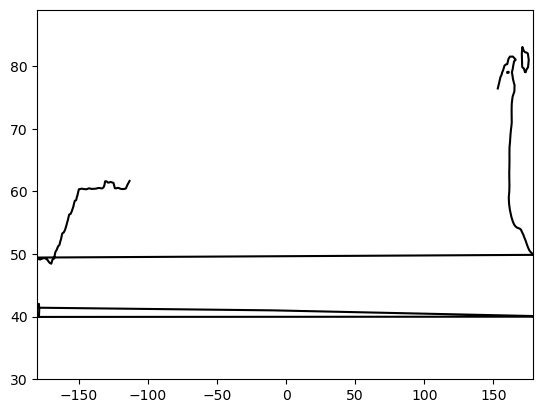

In [11]:
plt.contour(coords.i, coords.j, coords.Depth, levels=[1000], colors='k')

In [7]:
bottom_temp_wg = ds_tns.THETA.sel(time=slice('2005', '2012')).isel(k=depth_max.fillna(0.).astype('i4'))

In [ ]:
bottom_temp_wg_mean = bottom_temp_wg.mean(dim='time').load()

In [ ]:
surface_mask = (coords.hFacC[0]>0)#.load()

In [15]:
bottom_temp_wg_mean

<xarray.DataArray 'THETA' (j: 60, i: 95)>
array([[ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       ...,
       [ 0.28099158,  0.24135418,  0.2475027 , ..., -0.62010807,
        -0.6206312 , -0.6205287 ],
       [ 0.35721028,  0.27365103,  0.32195735, ..., -0.6191643 ,
        -0.6195022 , -0.62022126],
       [ 0.37651792,  0.3257186 ,  0.30054694, ..., -0.61835676,
        -0.6187758 , -0.6200681 ]], dtype=float32)
Coordinates:
  * i        (i) int64 153 154 155 156 157 158 ... -118 -117 -116 -115 -114 -113
  * j        (j) int64 30 31 32 33 34 35 36 37 38 ... 81 82 83 84 85 86 87 88 89
    k        (j, i) int64 0 0 0 0 0 0 0 0 0 0 ... 46 46 46 46 47 47 48 48 48 48

In [ ]:
bottom_temp_wg_mean['j'] = coords.j
bottom_temp_wg_mean['i'] = coords.i
bottom_temp_wg_mean

In [ ]:
lon = coords.XC
lat = coords.YC

In [ ]:
bottom_temp_wg_mean['lon'] = lon
bottom_temp_wg_mean['lat'] = lat

In [19]:
bottom_temp_wg_mean

<xarray.DataArray 'THETA' (j: 60, i: 95)>
array([[ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       ...,
       [ 0.28099158,  0.24135418,  0.2475027 , ..., -0.62010807,
        -0.6206312 , -0.6205287 ],
       [ 0.35721028,  0.27365103,  0.32195735, ..., -0.6191643 ,
        -0.6195022 , -0.62022126],
       [ 0.37651792,  0.3257186 ,  0.30054694, ..., -0.61835676,
        -0.6187758 , -0.6200681 ]], dtype=float32)
Coordinates:
  * i        (i) int64 153 154 155 156 157 158 ... -118 -117 -116 -115 -114 -113
  * j        (j) int64 30 31 32 33 34 35 36 37 38 ... 81 82 83 84 85 86 87 88 89
    k        (j, i) int64 0 0 0 0 0 0 0 0 0 0 ... 46 46 46 46 47 47 48 48 48 48
    lon      (j, i) float32 dask.array<chunksize=(60, 67), meta=np.ndarray>
    lat      (j, i) float32 dask.array<chunksize=(60, 67), meta=np.ndarray>

/srv/conda/envs/notebook/lib/python3.9/site-packages/cartopy/mpl/gridliner.py:451: UserWarning: The .xlabels_top attribute is deprecated. Please use .top_labels to toggle visibility instead.
  warnings.warn('The .xlabels_top attribute is deprecated. Please '
/srv/conda/envs/notebook/lib/python3.9/site-packages/cartopy/mpl/gridliner.py:487: UserWarning: The .ylabels_right attribute is deprecated. Please use .right_labels to toggle visibility instead.
  warnings.warn('The .ylabels_right attribute is deprecated. Please '


Text(0.5, 1.0, 'Bottom temperature from ECCO model\n averaged over 2005-2012')

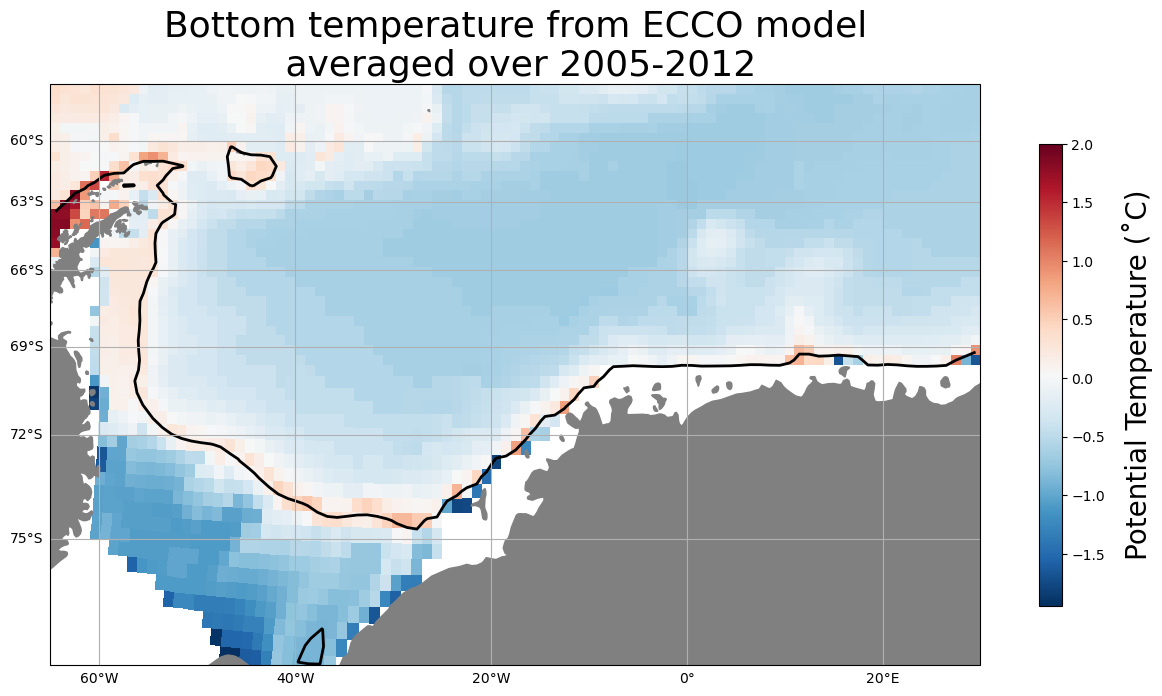

In [20]:
proj = ccrs.Mercator() #with Mercator you can put lat lon values.
fig, ax = plt.subplots(figsize=(15, 15), subplot_kw=dict(projection=proj))

ax.set_extent([-65, 30, -78, -57], crs=ccrs.PlateCarree())

ax.add_feature(cfeature.NaturalEarthFeature('physical', 'land', '50m',
                                        edgecolor='face',
                                        facecolor='0.5'))
#1000m isobath
ax.contour(lon, lat, coords.Depth, levels=[1000], colors='k', linewidths=2, transform=ccrs.PlateCarree())

im = ax.pcolormesh(lon, lat, bottom_temp_wg_mean.where(surface_mask), transform=ccrs.PlateCarree(), cmap='RdBu_r', vmax=2)
cb = fig.colorbar(im, ax=ax, shrink=0.4)
cb.set_label("Potential Temperature (˚C)", labelpad=12, fontsize=20)

g1 = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True)
g1.xlabels_top = False
g1.ylabels_right = False

#ax.text(-0.07, 0.55, 'Latitude', va='bottom', ha='center',
#        rotation='vertical', rotation_mode='anchor',
#        transform=ax.transAxes, fontsize=12)
#ax.text(0.5, -0.13, 'Longitude', va='bottom', ha='center',
#        rotation='horizontal', rotation_mode='anchor',
#        transform=ax.transAxes, fontsize=12)

plt.title('Bottom temperature from ECCO model\n averaged over 2005-2012', fontsize=26)
#plt.savefig('bot-temp-ecco-1kmisobath.pdf');

## <span style='color:Red'> Bottom Temperature Standard Deviation (start)

In [21]:
bottom_std_temp_wg = ds_tns.THETA.sel(time=slice('2005', '2012')).isel(k=depth_max.fillna(0.).astype('i4')).std('time')

In [22]:
bottom_std_temp_wg['lat'] = coords.YC
bottom_std_temp_wg['lon'] = coords.XC
bottom_std_temp_wg

<xarray.DataArray 'THETA' (j: 60, i: 95)>
dask.array<_sqrt, shape=(60, 95), dtype=float32, chunksize=(60, 95), chunktype=numpy.ndarray>
Coordinates:
  * i        (i) int64 153 154 155 156 157 158 ... -118 -117 -116 -115 -114 -113
  * j        (j) int64 30 31 32 33 34 35 36 37 38 ... 81 82 83 84 85 86 87 88 89
    k        (j, i) int64 0 0 0 0 0 0 0 0 0 0 ... 46 46 46 46 47 47 48 48 48 48
    lat      (j, i) float32 dask.array<chunksize=(60, 67), meta=np.ndarray>
    lon      (j, i) float32 dask.array<chunksize=(60, 67), meta=np.ndarray>

In [23]:
bottom_std_temp_wg.load()

<xarray.DataArray 'THETA' (j: 60, i: 95)>
array([[0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.0341949 , 0.04151517, 0.04022836, ..., 0.00674829, 0.00703088,
        0.00752147],
       [0.03162837, 0.0418316 , 0.03791399, ..., 0.00637237, 0.00649403,
        0.00725547],
       [0.03633543, 0.03848284, 0.03689783, ..., 0.00661306, 0.00691542,
        0.00763086]], dtype=float32)
Coordinates:
  * i        (i) int64 153 154 155 156 157 158 ... -118 -117 -116 -115 -114 -113
  * j        (j) int64 30 31 32 33 34 35 36 37 38 ... 81 82 83 84 85 86 87 88 89
    k        (j, i) int64 0 0 0 0 0 0 0 0 0 0 ... 46 46 46 46 47 47 48 48 48 48
    lat      (j, i) float32 -80.07 -80.14 -80.21 -80.27 ... -57.27 -57.27 -57.27
    lon      (j, i) float32 -71.48 -70.46 -69.43 -68.39 ... 26.5 27.5 28.5 29.5

/srv/conda/envs/notebook/lib/python3.9/site-packages/cartopy/mpl/gridliner.py:451: UserWarning: The .xlabels_top attribute is deprecated. Please use .top_labels to toggle visibility instead.
  warnings.warn('The .xlabels_top attribute is deprecated. Please '
/srv/conda/envs/notebook/lib/python3.9/site-packages/cartopy/mpl/gridliner.py:487: UserWarning: The .ylabels_right attribute is deprecated. Please use .right_labels to toggle visibility instead.
  warnings.warn('The .ylabels_right attribute is deprecated. Please '


Text(0.5, 1.0, 'Standard Deviation of bottom temperature \n from ECCO model averaged over 2005-2012')

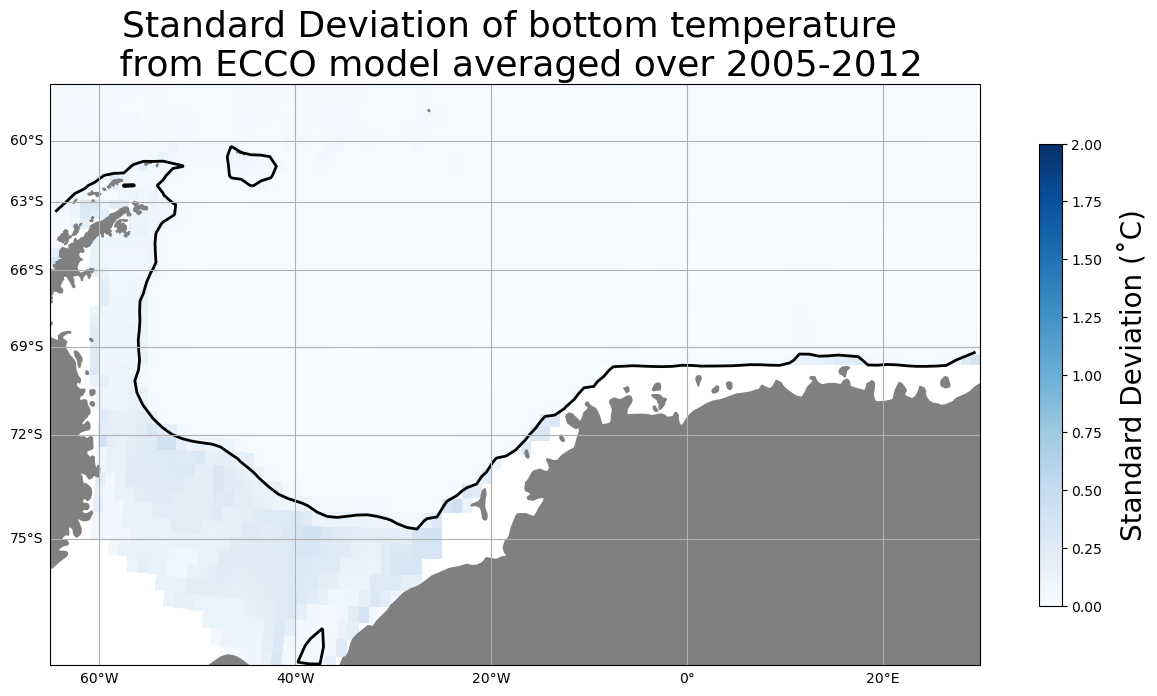

In [24]:
proj = ccrs.Mercator() #with Mercator you can put lat lon values.
fig, ax = plt.subplots(figsize=(15, 15), subplot_kw=dict(projection=proj))

ax.set_extent([-65, 30, -78, -57], crs=ccrs.PlateCarree())

ax.add_feature(cfeature.NaturalEarthFeature('physical', 'land', '50m',
                                        edgecolor='face',
                                        facecolor='0.5'))
#1000m isobath
ax.contour(lon, lat, coords.Depth, levels=[1000], colors='k', linewidths=2, transform=ccrs.PlateCarree())

im = ax.pcolormesh(lon, lat, bottom_std_temp_wg.where(surface_mask), transform=ccrs.PlateCarree(), 
                   cmap='Blues', vmin=0, vmax=2)
cb = fig.colorbar(im, ax=ax, shrink=0.4)
cb.set_label("Standard Deviation (˚C)", labelpad=12, fontsize=20)

g1 = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True)
g1.xlabels_top = False
g1.ylabels_right = False

#ax.text(-0.07, 0.55, 'Latitude', va='bottom', ha='center',
#        rotation='vertical', rotation_mode='anchor',
#        transform=ax.transAxes, fontsize=12)
#ax.text(0.5, -0.13, 'Longitude', va='bottom', ha='center',
#        rotation='horizontal', rotation_mode='anchor',
#        transform=ax.transAxes, fontsize=12)

plt.title('Standard Deviation of bottom temperature \n from ECCO model averaged over 2005-2012', fontsize=26)
#plt.savefig('std-bot-temp-ecco-1kmisobath.pdf');

## <span style='color:Red'> Bottom Temperature Deviation (end)

## Bottom Salinity

In [25]:
bottom_slt_wg = ds_tns.SALT.sel(time=slice('2005', '2012')).isel(k=depth_max.fillna(0.).astype('i4'))

In [26]:
bottom_slt_wg['lat'] = coords.YC
bottom_slt_wg['lon'] = coords.XC

In [27]:
bottom_slt_wg_mean = bottom_slt_wg.mean(dim='time')

In [28]:
bottom_slt_wg_mean['j'] = coords.j
bottom_slt_wg_mean['i'] = coords.i
bottom_slt_wg_mean.load()

<xarray.DataArray 'SALT' (j: 60, i: 95)>
array([[ 0.      ,  0.      ,  0.      , ...,  0.      ,  0.      ,
         0.      ],
       [ 0.      ,  0.      ,  0.      , ...,  0.      ,  0.      ,
         0.      ],
       [ 0.      ,  0.      ,  0.      , ...,  0.      ,  0.      ,
         0.      ],
       ...,
       [34.705166, 34.703896, 34.704174, ..., 34.67551 , 34.675064,
        34.674534],
       [34.707874, 34.70545 , 34.70699 , ..., 34.675095, 34.674564,
        34.674038],
       [34.708767, 34.707294, 34.706715, ..., 34.674526, 34.673935,
        34.67342 ]], dtype=float32)
Coordinates:
  * i        (i) int64 153 154 155 156 157 158 ... -118 -117 -116 -115 -114 -113
  * j        (j) int64 30 31 32 33 34 35 36 37 38 ... 81 82 83 84 85 86 87 88 89
    k        (j, i) int64 0 0 0 0 0 0 0 0 0 0 ... 46 46 46 46 47 47 48 48 48 48
    lat      (j, i) float32 -80.07 -80.14 -80.21 -80.27 ... -57.27 -57.27 -57.27
    lon      (j, i) float32 -71.48 -70.46 -69.43 -68.39 ... 26.5 27.5 28.5 29.5

/srv/conda/envs/notebook/lib/python3.9/site-packages/cartopy/mpl/gridliner.py:451: UserWarning: The .xlabels_top attribute is deprecated. Please use .top_labels to toggle visibility instead.
  warnings.warn('The .xlabels_top attribute is deprecated. Please '
/srv/conda/envs/notebook/lib/python3.9/site-packages/cartopy/mpl/gridliner.py:487: UserWarning: The .ylabels_right attribute is deprecated. Please use .right_labels to toggle visibility instead.
  warnings.warn('The .ylabels_right attribute is deprecated. Please '


Text(0.5, 1.0, 'Bottom salinity from ECCO model\n averaged over 2005-2012')

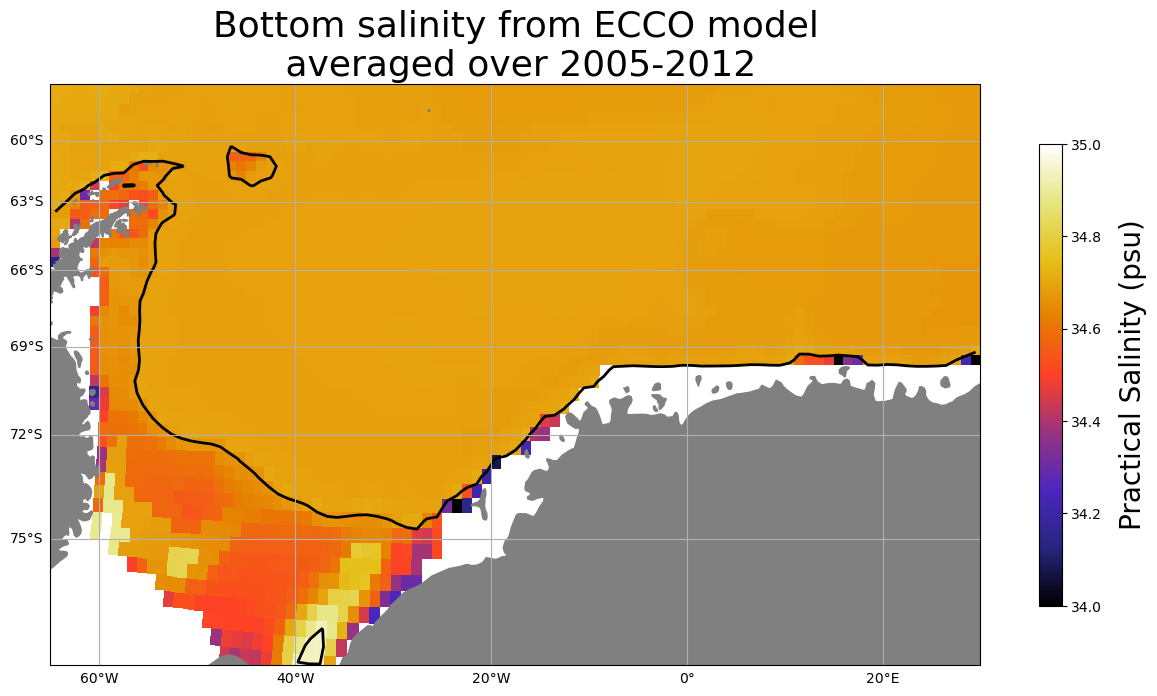

In [29]:
proj = ccrs.Mercator() #with Mercator you can put lat lon values.
fig, ax = plt.subplots(figsize=(15, 15), subplot_kw=dict(projection=proj))

ax.set_extent([-65, 30, -78, -57], crs=ccrs.PlateCarree())

ax.add_feature(cfeature.NaturalEarthFeature('physical', 'land', '50m',
                                            edgecolor='face',
                                            facecolor='0.5'))
#1000m isobath
ax.contour(lon, lat, coords.Depth, levels=[1000], colors='k', linewidths=2, transform=ccrs.PlateCarree())

im = ax.pcolormesh(lon, lat, bottom_slt_wg_mean.where(surface_mask), transform=ccrs.PlateCarree(), 
                   cmap='CMRmap', vmin=34, vmax=35)
cb = fig.colorbar(im, ax=ax, shrink=0.4)
cb.set_label("Practical Salinity (psu)", labelpad=12, fontsize=20)

g1 = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True)
g1.xlabels_top = False
g1.ylabels_right = False

#ax.text(-0.07, 0.55, 'Latitude', va='bottom', ha='center',
#        rotation='vertical', rotation_mode='anchor',
#        transform=ax.transAxes, fontsize=12)
#ax.text(0.5, -0.13, 'Longitude', va='bottom', ha='center',
#        rotation='horizontal', rotation_mode='anchor',
#        transform=ax.transAxes, fontsize=12)

plt.title('Bottom salinity from ECCO model\n averaged over 2005-2012', fontsize=26)
#plt.savefig('bot-salt-ecco-1kmisobath.pdf');

## <span style='color:Red'> Bottom Salinity Standard Deviation (start)

In [30]:
bottom_std_slt_wg = ds_tns.SALT.sel(time=slice('2005', '2012')).isel(k=depth_max.fillna(0.).astype('i4')).std('time')

In [31]:
bottom_std_slt_wg['lat'] = coords.YC
bottom_std_slt_wg['lon'] = coords.XC
bottom_std_slt_wg

<xarray.DataArray 'SALT' (j: 60, i: 95)>
dask.array<_sqrt, shape=(60, 95), dtype=float32, chunksize=(60, 95), chunktype=numpy.ndarray>
Coordinates:
  * i        (i) int64 153 154 155 156 157 158 ... -118 -117 -116 -115 -114 -113
  * j        (j) int64 30 31 32 33 34 35 36 37 38 ... 81 82 83 84 85 86 87 88 89
    k        (j, i) int64 0 0 0 0 0 0 0 0 0 0 ... 46 46 46 46 47 47 48 48 48 48
    lat      (j, i) float32 dask.array<chunksize=(60, 67), meta=np.ndarray>
    lon      (j, i) float32 dask.array<chunksize=(60, 67), meta=np.ndarray>

In [32]:
bottom_std_slt_wg.load()

<xarray.DataArray 'SALT' (j: 60, i: 95)>
array([[0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.00129873, 0.00156671, 0.00153141, ..., 0.00243559, 0.00245918,
        0.00244831],
       [0.00117342, 0.00152761, 0.00137957, ..., 0.00248125, 0.00250728,
        0.00249592],
       [0.00126863, 0.0013742 , 0.00133561, ..., 0.00251452, 0.00251891,
        0.00250288]], dtype=float32)
Coordinates:
  * i        (i) int64 153 154 155 156 157 158 ... -118 -117 -116 -115 -114 -113
  * j        (j) int64 30 31 32 33 34 35 36 37 38 ... 81 82 83 84 85 86 87 88 89
    k        (j, i) int64 0 0 0 0 0 0 0 0 0 0 ... 46 46 46 46 47 47 48 48 48 48
    lat      (j, i) float32 -80.07 -80.14 -80.21 -80.27 ... -57.27 -57.27 -57.27
    lon      (j, i) float32 -71.48 -70.46 -69.43 -68.39 ... 26.5 27.5 28.5 29.5

/srv/conda/envs/notebook/lib/python3.9/site-packages/cartopy/mpl/gridliner.py:451: UserWarning: The .xlabels_top attribute is deprecated. Please use .top_labels to toggle visibility instead.
  warnings.warn('The .xlabels_top attribute is deprecated. Please '
/srv/conda/envs/notebook/lib/python3.9/site-packages/cartopy/mpl/gridliner.py:487: UserWarning: The .ylabels_right attribute is deprecated. Please use .right_labels to toggle visibility instead.
  warnings.warn('The .ylabels_right attribute is deprecated. Please '


Text(0.5, 1.0, 'Standard deviation of bottom salinity \n from ECCO model averaged over 2005-2012')

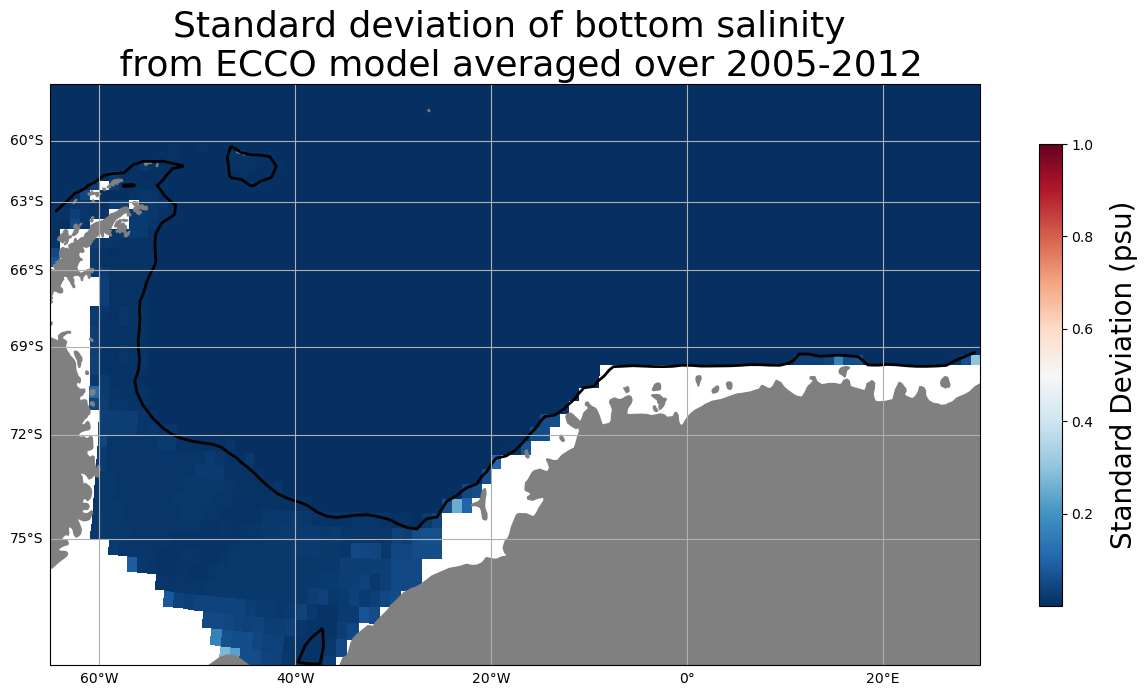

In [33]:
proj = ccrs.Mercator() #with Mercator you can put lat lon values.
fig, ax = plt.subplots(figsize=(15, 15), subplot_kw=dict(projection=proj))

ax.set_extent([-65, 30, -78, -57], crs=ccrs.PlateCarree())

ax.add_feature(cfeature.NaturalEarthFeature('physical', 'land', '50m',
                                            edgecolor='face',
                                            facecolor='0.5'))
#1000m isobath
ax.contour(lon, lat, coords.Depth, levels=[1000], colors='k', linewidths=2, transform=ccrs.PlateCarree())

im = ax.pcolormesh(lon, lat, bottom_std_slt_wg.where(surface_mask), transform=ccrs.PlateCarree(), cmap='RdBu_r', vmax=1)
cb = fig.colorbar(im, ax=ax, shrink=0.4)
cb.set_label("Standard Deviation (psu)", labelpad=12, fontsize=20)

g1 = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True)
g1.xlabels_top = False
g1.ylabels_right = False

#ax.text(-0.07, 0.55, 'Latitude', va='bottom', ha='center',
#        rotation='vertical', rotation_mode='anchor',
#        transform=ax.transAxes, fontsize=12)
#ax.text(0.5, -0.13, 'Longitude', va='bottom', ha='center',
#        rotation='horizontal', rotation_mode='anchor',
#        transform=ax.transAxes, fontsize=12)

plt.title('Standard deviation of bottom salinity \n from ECCO model averaged over 2005-2012', fontsize=26)
#plt.savefig('std-bot-salt-ecco-1kmisobath.pdf');

## <span style='color:Red'> Bottom Salinity Standard Deviation (end)

In [10]:
surface_mask.to_netcdf('surface_mask.nc')

In [42]:
coords.Depth.to_netcdf('depth.nc')

In [43]:
bottom_temp_wg_mean.to_netcdf('bottom_temp.nc')

In [44]:
lon.to_netcdf('lon.nc')

In [45]:
lat.to_netcdf('lat.nc')

In [46]:
bottom_std_temp_wg.to_netcdf('bottom_std_temp.nc')

In [47]:
bottom_slt_wg_mean.to_netcdf('bottom_slt.nc')

In [48]:
bottom_std_slt_wg.to_netcdf('bottom_std_slt.nc')